In [186]:
import os
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from dataset import DFUDataset
from loss import DiceLoss, BCEWithLogitsLoss
from optimiser import SGD, Adam
from model import UNet, DeepLabV3_MobileNet_V3_Large
from readFiles import ReadFiles
from training import Train
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

def ReadDirectories():
    print("Reading files from directories.")
    data_path = ""
    # Set training directory
    train_dir = os.path.join(data_path, "dfuc2022/train/images")
    train_mask_dir = os.path.join(data_path, "dfuc2022//train/masks")

    # Set validation directory
    val_dir = os.path.join(data_path, "dfuc2022/val/images")
    val_mask_dir = os.path.join(data_path, "dfuc2022/val/masks")

    # Set test directory
    test_dir = os.path.join(data_path, "dfuc2022/test/")

    train_files = ReadFiles(train_dir)
    train_masks = ReadFiles(train_mask_dir)

    val_files = ReadFiles(val_dir)
    val_masks = ReadFiles(val_mask_dir)

    test_files = ReadFiles(test_dir)
    print("Complete.")

    return train_files, train_masks, val_files, val_masks, test_files

In [228]:
def Transforms():
    transform_train = A.Compose([
        #A.augmentations.dropout.cutout.Cutout(num_holes=8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.RandomBrightnessContrast(p=0.2),
        #ToTensorV2(),
        #A.augmentations.transforms.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
        #A.augmentations.geometric.transforms.ShiftScaleRotate(
        #    shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, p=0.5),
        ToTensorV2(),
    ])

    transform_test = A.Compose([
        ToTensorV2(),
    ])

    return transform_train, transform_test

In [229]:
# Read directories into file lists.
train_files, train_masks, val_files, val_masks, test_files = ReadDirectories()

# Get transformations from Transforms()
transform_train, transform_test = Transforms()

# Generate manual seed for reproducability
torch.manual_seed(42)

Reading files from directories.
Complete.


In [230]:

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
val_ds = DFUDataset(val_files, val_masks, transform=transform_test)
print("Complete.")

image, label = train_ds[0]

Loading datasets...
Complete.


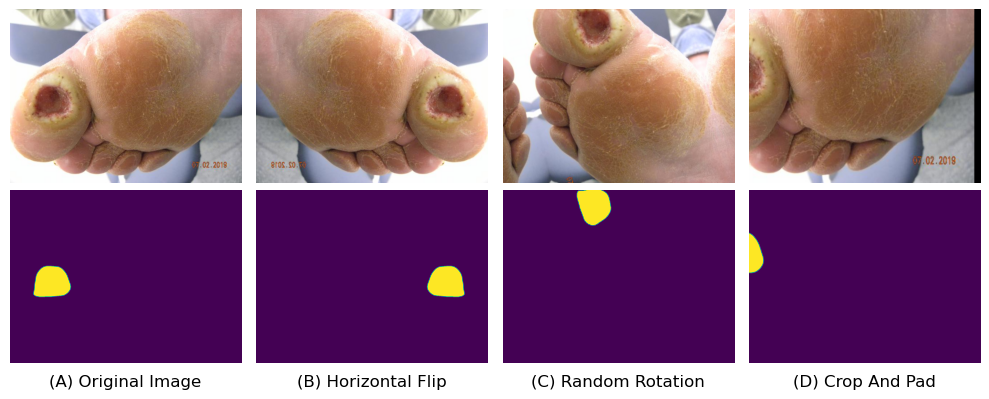

In [231]:
fig, axs = plt.subplots(2,4, figsize=(10,4))

aug = [
    A.Compose([A.HorizontalFlip(p=1),ToTensorV2()]),
    A.Compose([A.augmentations.geometric.rotate.Rotate(limit=90, p=1),ToTensorV2()]),
    A.Compose([A.augmentations.crops.transforms.CropAndPad(percent=(-0.3, 0.05), keep_size=True, p=1),ToTensorV2()]),
    ]

titles = ['(A) Original Image','(B) Horizontal Flip', '(C) Random Rotation', '(D) Crop And Pad']


axs[0, 0].imshow(image.permute(1,2,0));
axs[0, 0].axis('off')
axs[1, 0].imshow(label);
axs[1, 0].axis('off')
axs[1, 0].set_title(titles[0], y=-0.18)

for i in range(0,len(aug)):
    transform_train = aug[i]
    train_ds = DFUDataset(train_files, train_masks, transform=transform_train)

    image, label = train_ds[0]
    axs[0, i+1].imshow(image.permute(1,2,0));
    axs[0, i+1].axis('off')
    axs[1, i+1].imshow(label);
    axs[1, i+1].axis('off')
    axs[1, i+1].set_title(titles[i+1], y=-0.18)

plt.tight_layout()
plt.show()


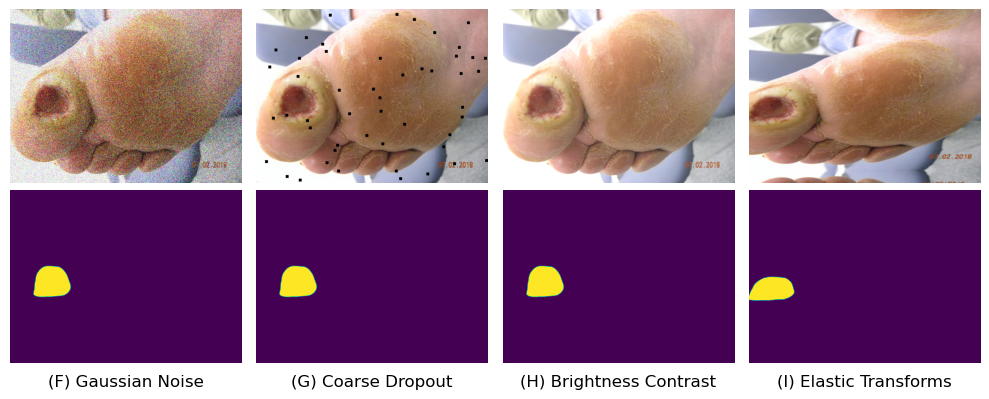

In [213]:
fig, axs = plt.subplots(2,4, figsize=(10,4))

aug = [
    A.Compose([A.augmentations.transforms.GaussNoise(var_limit=(1000.0, 5000.0), mean=0, per_channel=True, always_apply=False, p=1),ToTensorV2()]),
    A.Compose([A.augmentations.dropout.coarse_dropout.CoarseDropout(max_holes=50, max_height=8, max_width=8, p=1),ToTensorV2()]),
    A.Compose([A.RandomBrightnessContrast(p=1),ToTensorV2()]),
    A.Compose([A.augmentations.geometric.transforms.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, p=1),ToTensorV2()]),
    ]

titles = ['(F) Gaussian Noise','(G) Coarse Dropout', '(H) Brightness Contrast', '(I) Elastic Transforms']

for i in range(0,len(aug)):
    transform_train = aug[i]
    train_ds = DFUDataset(train_files, train_masks, transform=transform_train)

    image, label = train_ds[0]
    axs[0, i].imshow(image.permute(1,2,0));
    axs[0, i].axis('off')
    axs[1, i].imshow(label);
    axs[1, i].axis('off')
    axs[1, i].set_title(titles[i], y=-0.18)

plt.tight_layout()
plt.show()

## Horizontal Flip

In [177]:
transform_train = A.Compose([
        A.augmentations.transforms.GaussNoise(var_limit=(100.0, 5000.0), p=1),
        ToTensorV2(),
    ])

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
val_ds = DFUDataset(val_files, val_masks, transform=transform_test)
print("Complete.")


Loading datasets...
Complete.


In [178]:
train_ds[0]

(tensor([[[0.9451, 0.9255, 1.0000,  ..., 0.6431, 0.6784, 0.6667],
          [1.0000, 0.9725, 1.0000,  ..., 0.5843, 0.7059, 0.6039],
          [0.7843, 0.9529, 1.0000,  ..., 0.5922, 0.6941, 0.6784],
          ...,
          [1.0000, 0.9647, 0.8941,  ..., 0.5098, 0.4353, 0.4392],
          [0.9216, 0.8941, 0.9255,  ..., 0.4078, 0.4706, 0.5098],
          [0.8000, 0.8902, 0.8784,  ..., 0.4510, 0.4196, 0.3725]],
 
         [[0.9765, 0.7725, 1.0000,  ..., 0.5882, 0.4510, 0.6275],
          [1.0000, 0.9843, 0.9882,  ..., 0.4902, 0.5412, 0.6353],
          [0.8667, 1.0000, 0.9294,  ..., 0.5098, 0.6118, 0.4863],
          ...,
          [0.9020, 1.0000, 1.0000,  ..., 0.4314, 0.5255, 0.5569],
          [1.0000, 1.0000, 0.9804,  ..., 0.4706, 0.4431, 0.4510],
          [0.9490, 0.8980, 1.0000,  ..., 0.5608, 0.4667, 0.5765]],
 
         [[0.9255, 0.9529, 1.0000,  ..., 0.5725, 0.4745, 0.5569],
          [0.9137, 1.0000, 0.9686,  ..., 0.4902, 0.4745, 0.5922],
          [1.0000, 1.0000, 0.9843,  ...,

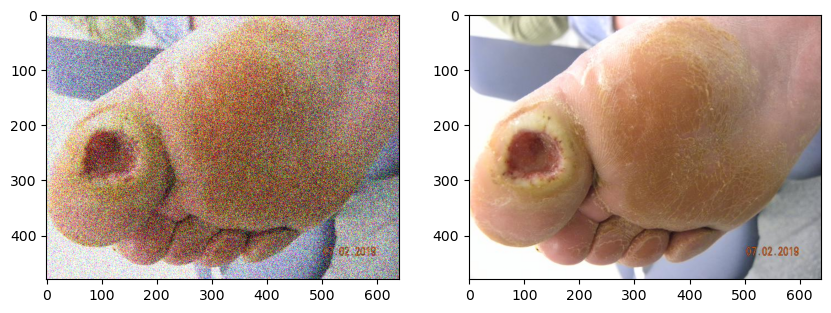

In [179]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
axs[0].imshow(train_ds[0][0].permute(1,2,0));
axs[1].imshow(original_image.permute(1,2,0));

Loading datasets...
Complete.


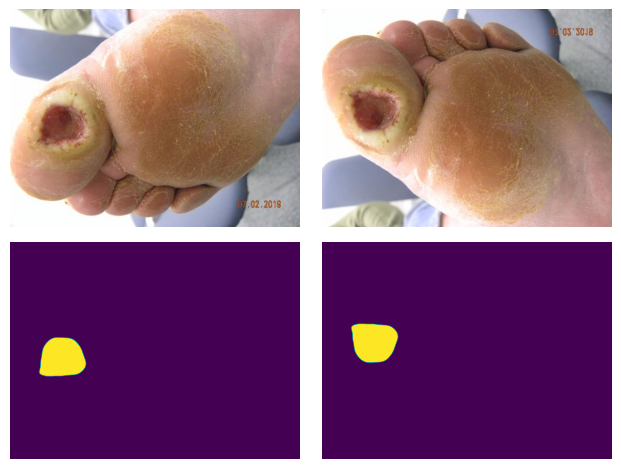

In [81]:
transform_train = A.Compose([
        A.VerticalFlip(p=1),
        ToTensorV2(),
    ])

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
print("Complete.")

augPlots(train_ds[0])

## Rotation

Loading datasets...
Complete.


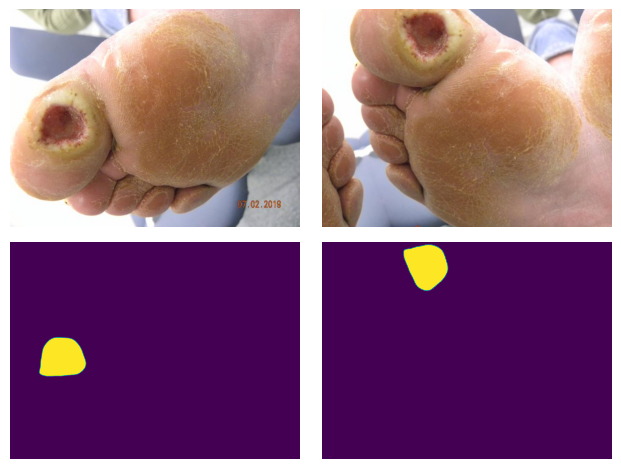

In [89]:
transform_train = A.Compose([
        A.augmentations.geometric.rotate.Rotate(limit=90, p=1),
        ToTensorV2(),
    ])

# Load dataset
print("Loading datasets...")
train_ds = DFUDataset(train_files, train_masks, transform=transform_train)
val_ds = DFUDataset(val_files, val_masks, transform=transform_test)
print("Complete.")

augPlots(train_ds[0])